In [17]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import matplotlib.ticker as ticker

In [18]:
alphas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
betas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
criterion = 'l2-sp'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'val_acc', 'val_nll']
tuned_df = pd.DataFrame(columns=columns)

for alpha, beta, lr_0, n, random_state in itertools.product(alphas, betas, lr_0s, ns, random_states):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    tuned_df.loc[len(tuned_df)] = row
    
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10'

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'test_acc', 'test_nll']
retrained_df = pd.DataFrame(columns=columns)

for index, row in tuned_df.iterrows():
    temp_df = pd.read_csv(f'{experiments_directory}/{row.model_name}.csv')
    row = [row.criterion, row.model_name, row.n, row.random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    retrained_df.loc[len(retrained_df)] = row

retrained_df

,criterion,model_name,n,random_state,runtime,test_acc,test_nll
0,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=100_rand...,100,1001,1731.240962,0.5813,1.322462
1,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=100_rand...,100,2001,1711.419768,0.5562,1.386775
2,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=100_rand...,100,3001,1720.188420,0.6234,1.151327
3,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=1000_ran...,1000,1001,2124.317451,0.8842,0.384104
4,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=1000_ran...,1000,2001,2118.474334,0.8785,0.389773
...,...,...,...,...,...,...,...
1723,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=10000_r...,10000,2001,2285.013988,0.8152,0.849668
1724,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=10000_r...,10000,3001,2265.344910,0.8094,0.841590
1725,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=50000_r...,50000,1001,2087.493067,0.8026,0.851022
1726,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=50000_r...,50000,2001,2229.805646,0.8148,0.853667


In [19]:
tuned_df.to_csv('tuned_CIFAR-10_ResNet_50.csv', index=False)
retrained_df.to_csv('retrained_CIFAR-10_ResNet_50.csv', index=False)

In [21]:
alphas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
betas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
criterion = 'l2-sp'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/Oxford-IIIT_Pet'
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_Oxford-IIIT_Pet'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'val_acc', 'val_nll']
tuned_df = pd.DataFrame(columns=columns)

for alpha, beta, lr_0, n, random_state in itertools.product(alphas, betas, lr_0s, ns, random_states):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    tuned_df.loc[len(tuned_df)] = row
    
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet'

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'test_acc', 'test_nll']
retrained_df = pd.DataFrame(columns=columns)

for index, row in tuned_df.iterrows():
    temp_df = pd.read_csv(f'{experiments_directory}/{row.model_name}.csv')
    row = [row.criterion, row.model_name, row.n, row.random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    retrained_df.loc[len(retrained_df)] = row

retrained_df

,criterion,model_name,n,random_state,runtime,test_acc,test_nll
0,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=370_rand...,370,1001,1370.007978,0.749886,0.960920
1,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=370_rand...,370,2001,1408.123719,0.755925,0.952158
2,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=370_rand...,370,3001,1401.989089,0.766192,0.933798
3,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=3441_ran...,3441,1001,1400.816236,0.928762,0.279900
4,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=3441_ran...,3441,2001,1403.407756,0.927361,0.277136
...,...,...,...,...,...,...,...
859,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=370_ran...,370,2001,1473.484066,0.878151,0.801126
860,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=370_ran...,370,3001,1411.118942,0.888890,0.807195
861,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=3441_ra...,3441,1001,2214.709541,0.869254,0.900682
862,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=3441_ra...,3441,2001,1890.625961,0.870332,0.899985


In [22]:
tuned_df.to_csv('tuned_Oxford-IIIT_Pet_ResNet_50.csv', index=False)
retrained_df.to_csv('retrained_Oxford-IIIT_Pet_ResNet_50.csv', index=False)

In [23]:
alphas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
betas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
criterion = 'l2-sp'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/Flowers_102'
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_Flowers_102'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [510, 1020]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'val_acc', 'val_nll']
tuned_df = pd.DataFrame(columns=columns)

for alpha, beta, lr_0, n, random_state in itertools.product(alphas, betas, lr_0s, ns, random_states):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    tuned_df.loc[len(tuned_df)] = row
    
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flowers_102'

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'test_acc', 'test_nll']
retrained_df = pd.DataFrame(columns=columns)

for index, row in tuned_df.iterrows():
    temp_df = pd.read_csv(f'{experiments_directory}/{row.model_name}.csv')
    row = [row.criterion, row.model_name, row.n, row.random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    retrained_df.loc[len(retrained_df)] = row

retrained_df

,criterion,model_name,n,random_state,runtime,test_acc,test_nll
0,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=510_rand...,510,1001,1535.906535,0.755216,1.331653
1,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=510_rand...,510,2001,1488.316173,0.767106,1.246255
2,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=510_rand...,510,3001,1713.466016,0.778095,1.185361
3,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=1020_ran...,1020,1001,1468.438030,0.872380,0.697942
4,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=1020_ran...,1020,2001,1758.796065,0.882194,0.675922
...,...,...,...,...,...,...,...
859,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=510_ran...,510,2001,1483.410068,0.644529,3.215339
860,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=510_ran...,510,3001,1483.771694,0.640550,3.210751
861,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=1020_ra...,1020,1001,1464.862879,0.673903,3.254760
862,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=1020_ra...,1020,2001,1505.978922,0.650377,3.258630


In [8]:
tuned_df.to_csv('tuned_Flowers_102_ResNet_50.csv', index=False)
retrained_df.to_csv('retrained_Flowers_102_ResNet_50.csv', index=False)

In [9]:
cifar10_dictionary = np.load('CIFAR-10_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()
oxfordiiit_pet_dictionary = np.load('Oxford-IIIT_Pet_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()
flowers_102_dictionary = np.load('Flowers_102_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()

In [46]:
#d = 23528522
#d = 85806346
d = 27827818
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_de_elbo_tuned_df.loc[len(cifar10_de_elbo_tuned_df)] = row
    
min_indices = cifar10_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_de_elbo_retrained_df = cifar10_de_elbo_tuned_df.loc[min_indices]
cifar10_de_elbo_retrained_df['total_time'] = cifar10_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [47]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_elbo_tuned_df.loc[len(cifar10_elbo_tuned_df)] = row
    
min_indices = cifar10_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_elbo_retrained_df = cifar10_elbo_tuned_df.loc[min_indices]
cifar10_elbo_retrained_df['total_time'] = cifar10_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [48]:
#d = 23583845
#d = 85827109
d = 27848581
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
oxfordiiit_pet_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    oxfordiiit_pet_de_elbo_tuned_df.loc[len(oxfordiiit_pet_de_elbo_tuned_df)] = row
    
min_indices = oxfordiiit_pet_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
oxfordiiit_pet_de_elbo_retrained_df = oxfordiiit_pet_de_elbo_tuned_df.loc[min_indices]
oxfordiiit_pet_de_elbo_retrained_df['total_time'] = oxfordiiit_pet_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [49]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
oxfordiiit_pet_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    oxfordiiit_pet_elbo_tuned_df.loc[len(oxfordiiit_pet_elbo_tuned_df)] = row
    
min_indices = oxfordiiit_pet_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
oxfordiiit_pet_elbo_retrained_df = oxfordiiit_pet_elbo_tuned_df.loc[min_indices]
oxfordiiit_pet_elbo_retrained_df['total_time'] = oxfordiiit_pet_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [50]:
#d = 23717030
#d = 85877094
d = 27898566
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flowers_102_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [510, 1020]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
flowers_102_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    flowers_102_de_elbo_tuned_df.loc[len(flowers_102_de_elbo_tuned_df)] = row
    
min_indices = flowers_102_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
flowers_102_de_elbo_retrained_df = flowers_102_de_elbo_tuned_df.loc[min_indices]
flowers_102_de_elbo_retrained_df['total_time'] = flowers_102_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [51]:
def plot_dictionary(ax, bootstrap_dictionary, n, random_states, markers=['o', '^', 's']):
    for index, random_state in enumerate(random_states):
        x = bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(0,2,))
        y = bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(0,2,))
        lower_x, upper_x = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        lower_y, upper_y = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        ax.scatter(x[-1]/3600, y[-1], color='#1F77B4', marker=markers[index], zorder=3)
        ax.plot(x/3600, y, color='#1F77B4', zorder=2)
        ax.fill_between(x/3600, lower_y, upper_y, alpha=0.1, color='#1F77B4', zorder=2)

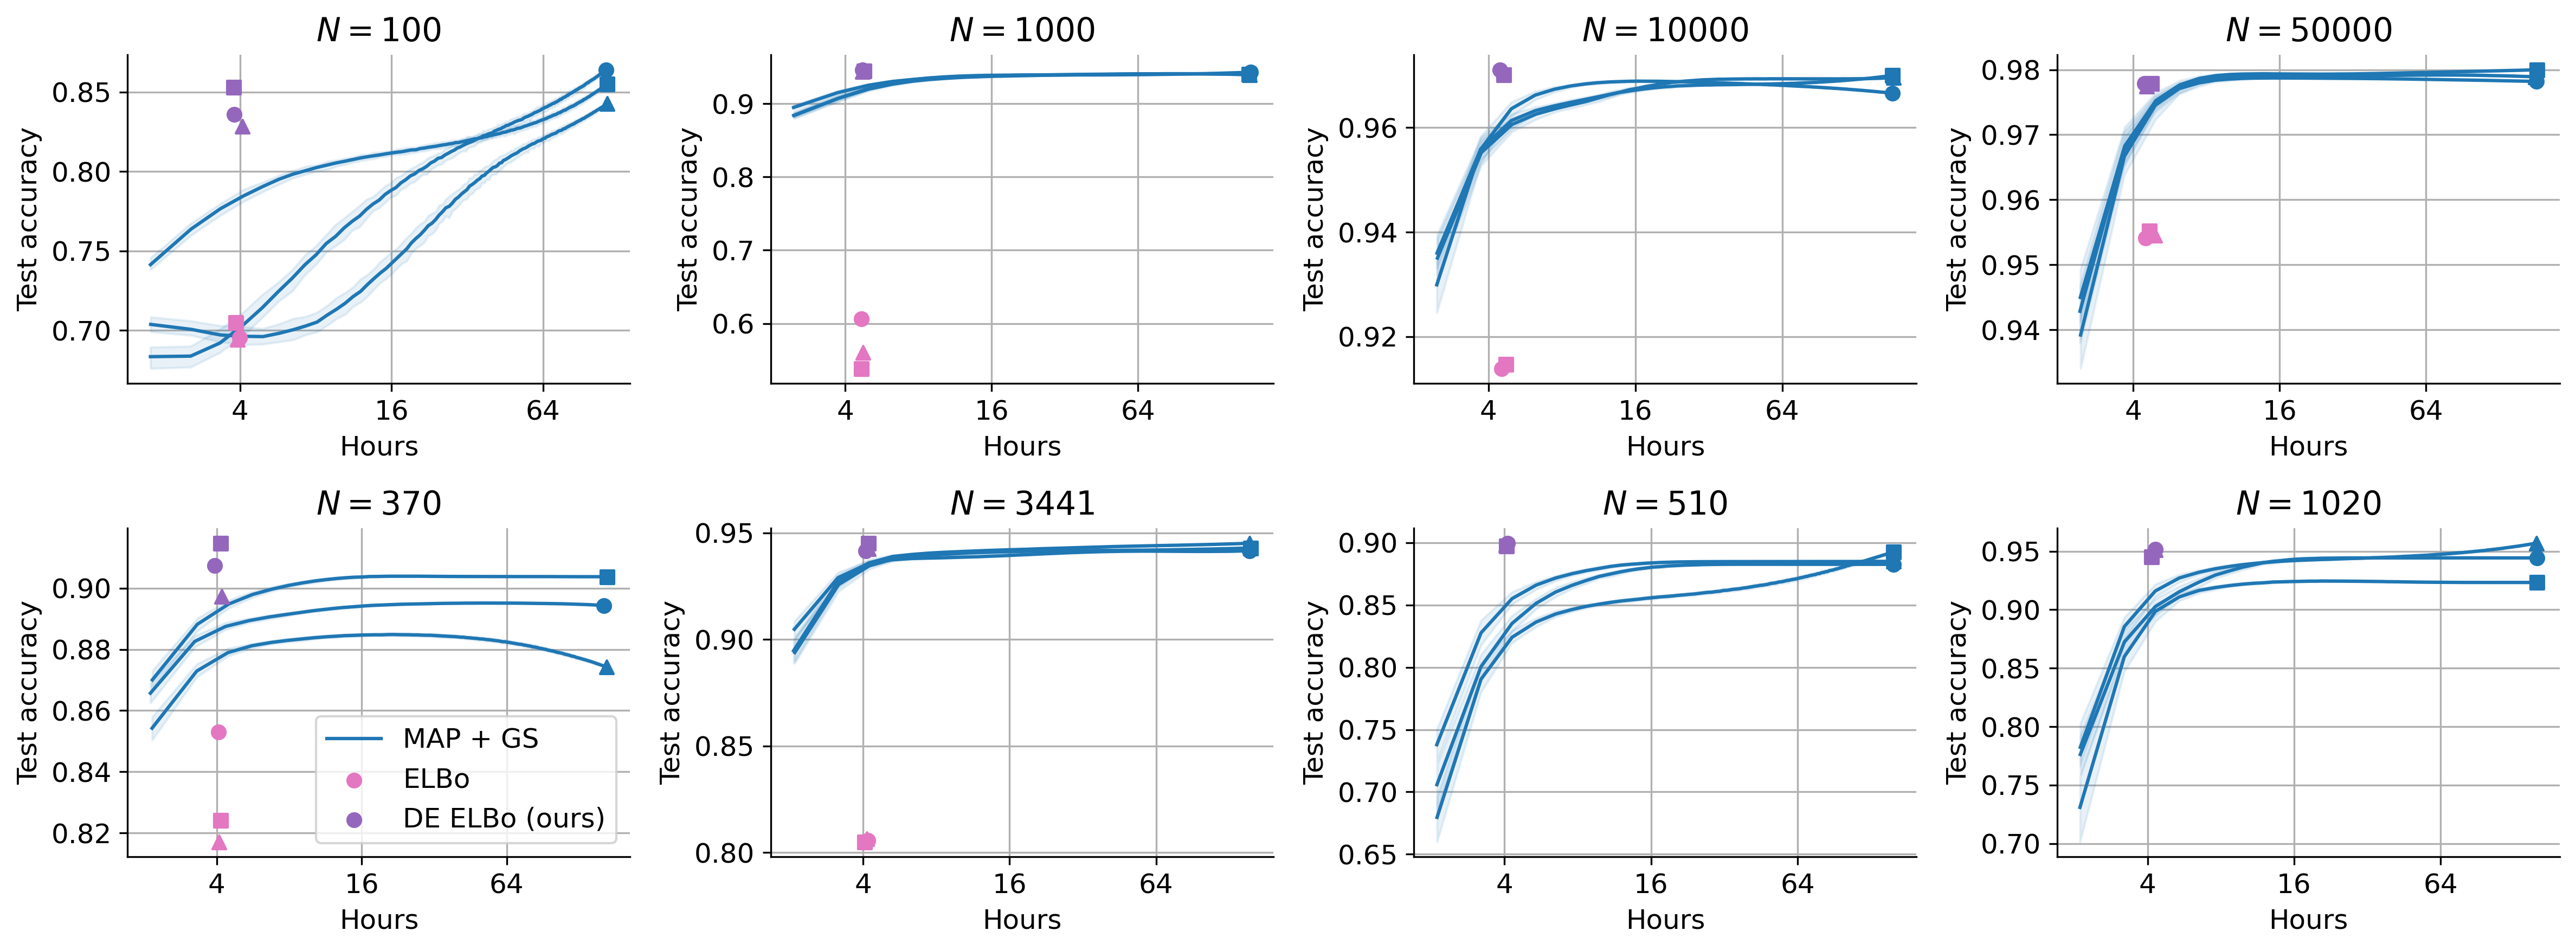

In [52]:
markers = ['o', '^', 's']

ncols, nrows = 4, 2
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==100].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(axs[0,0], cifar10_dictionary, 100, [1001, 2001, 3001])
axs[0,0].set_xscale('log', base=2)
ticks = axs[0,0].get_xticks()
axs[0,0].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,0].spines[['right', 'top']].set_visible(False)
axs[0,0].set_title(r'$N=100$')
axs[0,0].set_xlabel('Hours')
axs[0,0].set_ylabel('Test accuracy')
axs[0,0].grid()

for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==1000].test_acc.values)):
    axs[0,1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].test_acc.values)):
    axs[0,1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(axs[0,1], cifar10_dictionary, 1000, [1001, 2001, 3001])
axs[0,1].set_xscale('log', base=2)
ticks = axs[0,1].get_xticks()
axs[0,1].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,1].spines[['right', 'top']].set_visible(False)
axs[0,1].set_title(r'$N=1000$')
axs[0,1].set_xlabel('Hours')
axs[0,1].set_ylabel('Test accuracy')
axs[0,1].grid()

for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(axs[0,2], cifar10_dictionary, 10000, [1001, 2001, 3001])
axs[0,2].set_xscale('log', base=2)
ticks = axs[0,2].get_xticks()
axs[0,2].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,2].spines[['right', 'top']].set_visible(False)
axs[0,2].set_title(r'$N=10000$')
axs[0,2].set_xlabel('Hours')
axs[0,2].set_ylabel('Test accuracy')
axs[0,2].grid()

for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(axs[0,3], cifar10_dictionary, 50000, [1001, 2001, 3001])
axs[0,3].set_xscale('log', base=2)
ticks = axs[0,3].get_xticks()
axs[0,3].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,3].spines[['right', 'top']].set_visible(False)
axs[0,3].set_title(r'$N=50000$')
axs[0,3].set_xlabel('Hours')
axs[0,3].set_ylabel('Test accuracy')
axs[0,3].grid()

axs[1,0].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[1,0].scatter([], [], color='#E377C2', label='ELBo', zorder=3)
axs[1,0].scatter([], [], color='#9467BD', label='DE ELBo (ours)', zorder=3)
for index, (time, acc) in enumerate(zip(oxfordiiit_pet_de_elbo_retrained_df[oxfordiiit_pet_de_elbo_retrained_df.n==370].total_time.values/3600, oxfordiiit_pet_de_elbo_retrained_df[oxfordiiit_pet_de_elbo_retrained_df.n==370].test_acc.values)):
    axs[1,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(oxfordiiit_pet_elbo_retrained_df[oxfordiiit_pet_elbo_retrained_df.n==370].total_time.values/3600, oxfordiiit_pet_elbo_retrained_df[oxfordiiit_pet_elbo_retrained_df.n==370].test_acc.values)):
    axs[1,0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(axs[1,0], oxfordiiit_pet_dictionary, 370, [1001, 2001, 3001])
axs[1,0].set_xscale('log', base=2)
ticks = axs[1,0].get_xticks()
axs[1,0].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1,0].spines[['right', 'top']].set_visible(False)
axs[1,0].set_title(r'$N=370$')
axs[1,0].set_xlabel('Hours')
axs[1,0].set_ylabel('Test accuracy')
axs[1,0].grid()
axs[1,0].legend(loc='lower right')

for index, (time, acc) in enumerate(zip(oxfordiiit_pet_de_elbo_retrained_df[oxfordiiit_pet_de_elbo_retrained_df.n==3441].total_time.values/3600, oxfordiiit_pet_de_elbo_retrained_df[oxfordiiit_pet_de_elbo_retrained_df.n==3441].test_acc.values)):
    axs[1,1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(oxfordiiit_pet_elbo_retrained_df[oxfordiiit_pet_elbo_retrained_df.n==3441].total_time.values/3600, oxfordiiit_pet_elbo_retrained_df[oxfordiiit_pet_elbo_retrained_df.n==3441].test_acc.values)):
    axs[1,1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(axs[1,1], oxfordiiit_pet_dictionary, 3441, [1001, 2001, 3001])
axs[1,1].set_xscale('log', base=2)
ticks = axs[1,1].get_xticks()
axs[1,1].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1,1].spines[['right', 'top']].set_visible(False)
axs[1,1].set_title(r'$N=3441$')
axs[1,1].set_xlabel('Hours')
axs[1,1].set_ylabel('Test accuracy')
axs[1,1].grid()

for index, (time, acc) in enumerate(zip(flowers_102_de_elbo_retrained_df[flowers_102_de_elbo_retrained_df.n==510].total_time.values/3600, flowers_102_de_elbo_retrained_df[flowers_102_de_elbo_retrained_df.n==510].test_acc.values)):
    axs[1,2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[1,2], flowers_102_dictionary, 510, [1001, 2001, 3001])
axs[1,2].set_xscale('log', base=2)
ticks = axs[1,2].get_xticks()
axs[1,2].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1,2].spines[['right', 'top']].set_visible(False)
axs[1,2].set_title(r'$N=510$')
axs[1,2].set_xlabel('Hours')
axs[1,2].set_ylabel('Test accuracy')
axs[1,2].grid()

for index, (time, acc) in enumerate(zip(flowers_102_de_elbo_retrained_df[flowers_102_de_elbo_retrained_df.n==1020].total_time.values/3600, flowers_102_de_elbo_retrained_df[flowers_102_de_elbo_retrained_df.n==1020].test_acc.values)):
    axs[1,3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[1,3], flowers_102_dictionary, 1020, [1001, 2001, 3001])
axs[1,3].set_xscale('log', base=2)
ticks = axs[1,3].get_xticks()
axs[1,3].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1,3].spines[['right', 'top']].set_visible(False)
axs[1,3].set_title(r'$N=1020$')
axs[1,3].set_xlabel('Hours')
axs[1,3].set_ylabel('Test accuracy')
axs[1,3].grid()

fig.tight_layout()
fig.savefig('computational_time_comparison.pdf', bbox_inches='tight')
plt.show()

[0.525 0.55  0.575 0.6   0.625]
[0.8   0.825 0.85  0.875]
[0.8   0.825]
[0.  0.1]
[0.  0.1]


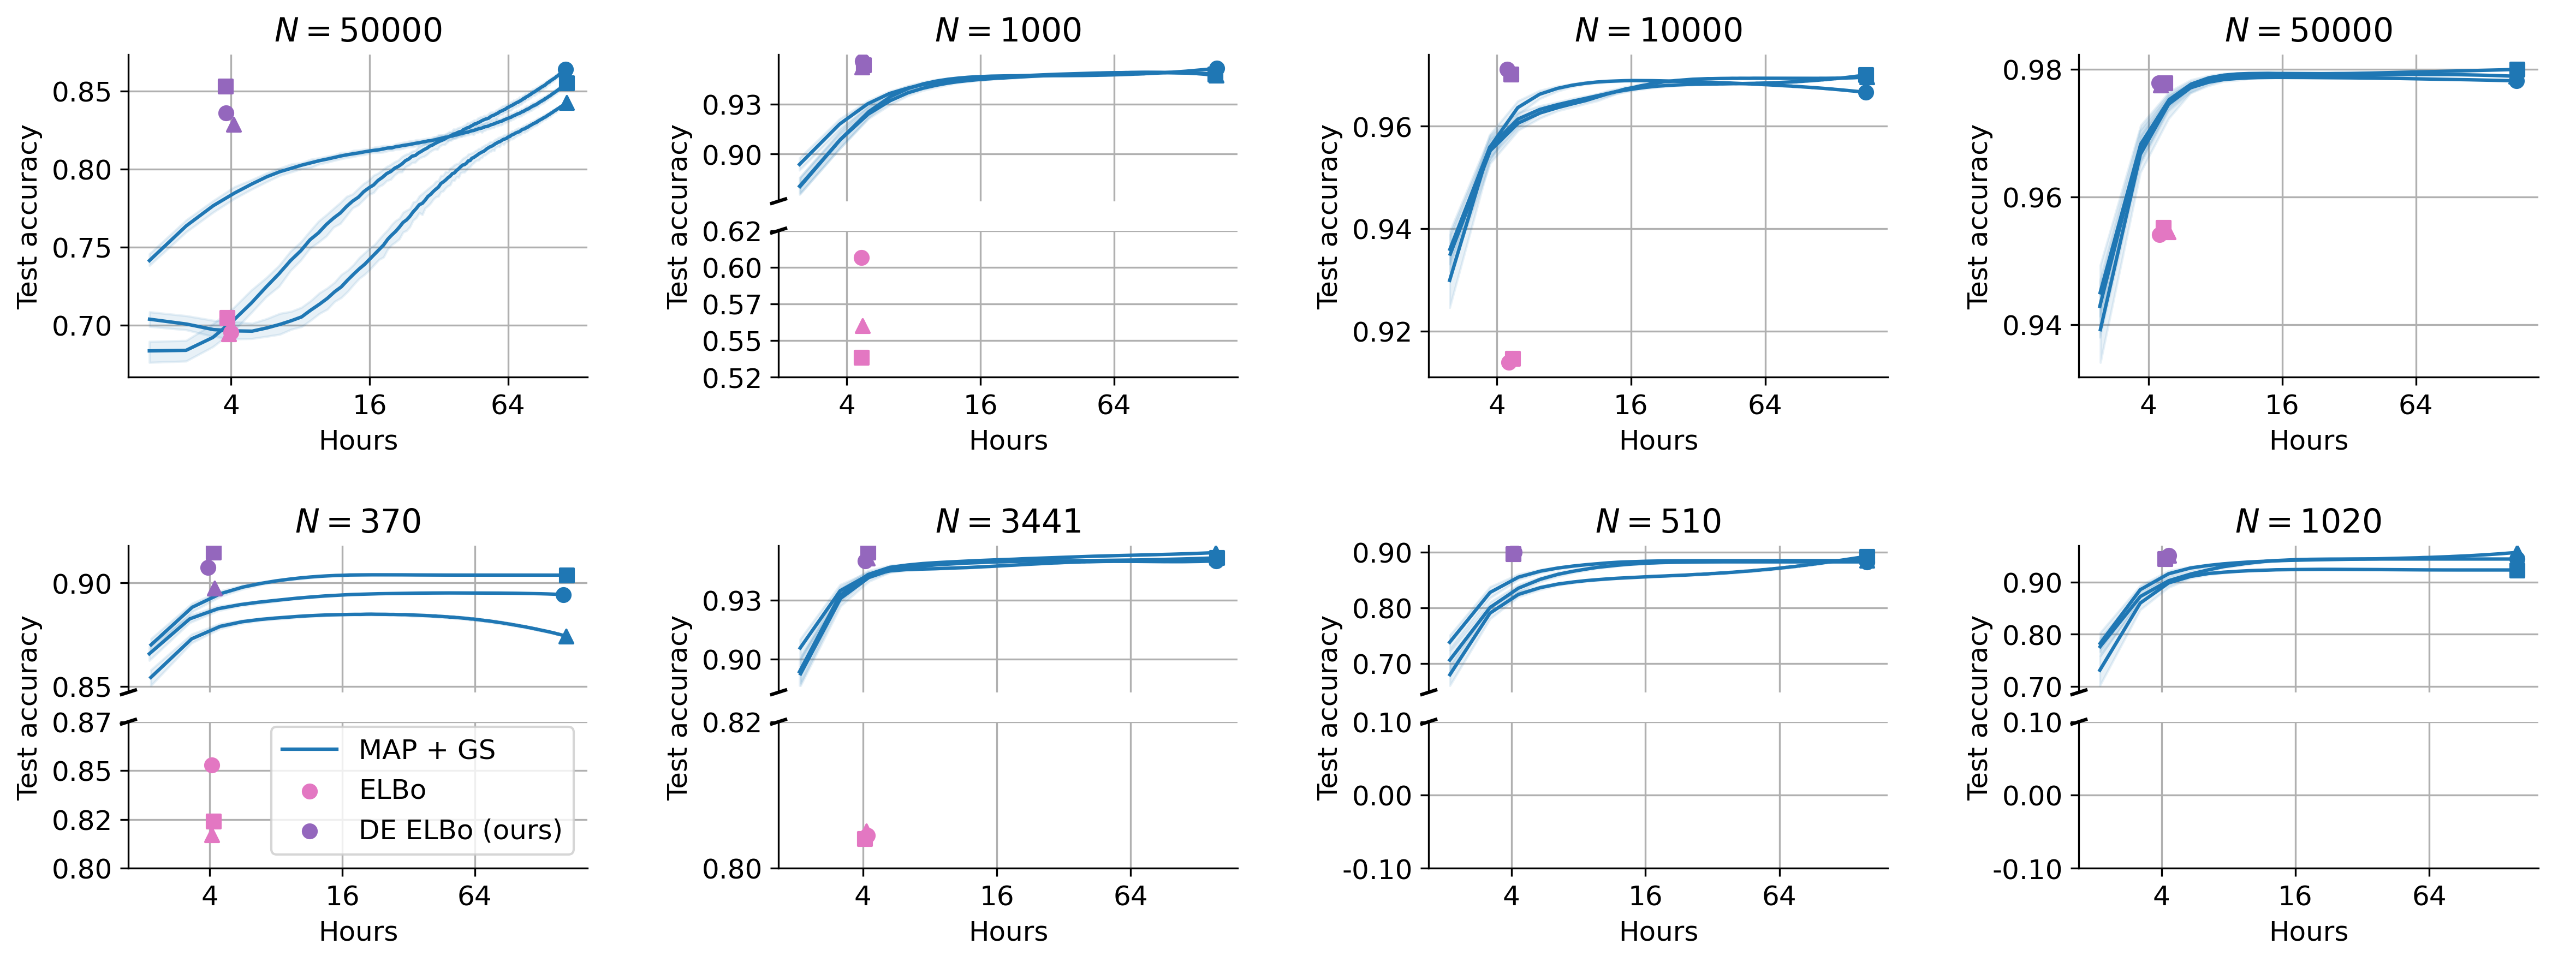

In [95]:
def adjust_layout(ax1, ax2):
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    height = ((pos1.y1-pos2.y0)/2)-0.015
    pos1.y0 = pos1.y1-height
    pos2.y1 = pos2.y0+height
    ax1.set_position(pos1)
    ax2.set_position(pos2)

def create_ylabel(fig, grid):
    ax = fig.add_subplot(grid)
    ax.set_ylabel('Test accuracy')
    ax.set_frame_on(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')

def create_brokenaxes(ax1, ax2):
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    d = 0.015
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    xlim = ax1.get_xlim()
    xticks = ax1.get_xticks()
    ax1.set_xticks([int(xtick) for xtick in xticks[2:-2]], [int(xtick) for xtick in xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(xlim)
    ax2.set_xticks([int(xtick) for xtick in xticks[2:-2]], [int(xtick) for xtick in xticks[2:-2]])
    
    yticks = ax1.get_yticks()
    interval = yticks[-1] - yticks[-2]
    ymin, ymax = ax2.get_ylim()
    print(np.arange(start=max(0, (ymin // interval) * interval), stop=(((ymax + interval) // interval) + 1) * interval, step=interval))
    ax2.set_yticks(np.arange(start=(ymin // interval) * interval, stop=(((ymax + interval) // interval) + 1) * interval, step=interval))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
ncols, nrows = 4, 4
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 1.5*nrows), ncols=ncols, nrows=nrows)
grid = plt.GridSpec(nrows=nrows, ncols=ncols)

axs[0,0].axis('off')
axs[1,0].axis('off')
ax = fig.add_subplot(grid[:2,0])

for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].test_acc.values)):
    ax.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==100].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==100].test_acc.values)):
    ax.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(ax, cifar10_dictionary, 100, [1001, 2001, 3001])

ax.set_xscale('log', base=2)
ticks = ax.get_xticks()
ax.set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(r'$N=100$')
ax.set_xlabel('Hours')
ax.set_ylabel('Test accuracy')
ax.grid()

for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].test_acc.values)):
    axs[1,1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==1000].test_acc.values)):
    axs[0,1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[0,1], cifar10_dictionary, 1000, [1001, 2001, 3001])

create_brokenaxes(axs[0,1], axs[1,1])
create_ylabel(fig, grid[:2,1])

axs[0,1].spines[['right', 'top']].set_visible(False)
axs[1,1].spines[['right', 'top']].set_visible(False)
axs[0,1].set_title(r'$N=1000$')
axs[1,1].set_xlabel('Hours')
axs[0,1].grid()
axs[1,1].grid()

axs[0,2].axis('off')
axs[1,2].axis('off')
ax = fig.add_subplot(grid[:2,2])

for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].test_acc.values)):
    ax.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].test_acc.values)):
    ax.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(ax, cifar10_dictionary, 10000, [1001, 2001, 3001])

ax.set_xscale('log', base=2)
ticks = ax.get_xticks()
ax.set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(r'$N=10000$')
ax.set_xlabel('Hours')
ax.set_ylabel('Test accuracy')
ax.grid()


ax = fig.add_subplot(grid[:2,3])

for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].test_acc.values)):
    ax.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].test_acc.values)):
    ax.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(ax, cifar10_dictionary, 50000, [1001, 2001, 3001])

ax.set_xscale('log', base=2)
ticks = ax.get_xticks()
ax.set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(r'$N=50000$')
ax.set_xlabel('Hours')
ax.set_ylabel('Test accuracy')
ax.grid()

axs[0,3].axis('off')
axs[1,3].axis('off')

axs[3,0].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[3,0].scatter([], [], color='#E377C2', label='ELBo', zorder=3)
axs[3,0].scatter([], [], color='#9467BD', label='DE ELBo (ours)', zorder=3)
axs[3,0].legend(loc='lower right')

for index, (time, acc) in enumerate(zip(oxfordiiit_pet_de_elbo_retrained_df[oxfordiiit_pet_de_elbo_retrained_df.n==370].total_time.values/3600, oxfordiiit_pet_de_elbo_retrained_df[oxfordiiit_pet_de_elbo_retrained_df.n==370].test_acc.values)):
    axs[2,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(oxfordiiit_pet_elbo_retrained_df[oxfordiiit_pet_elbo_retrained_df.n==370].total_time.values/3600, oxfordiiit_pet_elbo_retrained_df[oxfordiiit_pet_elbo_retrained_df.n==370].test_acc.values)):
    axs[3,0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(axs[2,0], oxfordiiit_pet_dictionary, 370, [1001, 2001, 3001])

create_brokenaxes(axs[2,0], axs[3,0])
create_ylabel(fig, grid[2:,0])

axs[2,0].spines[['right', 'top']].set_visible(False)
axs[3,0].spines[['right', 'top']].set_visible(False)
axs[2,0].set_title(r'$N=370$')
axs[3,0].set_xlabel('Hours')
axs[2,0].grid()
axs[3,0].grid()

for index, (time, acc) in enumerate(zip(oxfordiiit_pet_de_elbo_retrained_df[oxfordiiit_pet_de_elbo_retrained_df.n==3441].total_time.values/3600, oxfordiiit_pet_de_elbo_retrained_df[oxfordiiit_pet_de_elbo_retrained_df.n==3441].test_acc.values)):
    axs[2,1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(oxfordiiit_pet_elbo_retrained_df[oxfordiiit_pet_elbo_retrained_df.n==3441].total_time.values/3600, oxfordiiit_pet_elbo_retrained_df[oxfordiiit_pet_elbo_retrained_df.n==3441].test_acc.values)):
    axs[3,1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
plot_dictionary(axs[2,1], oxfordiiit_pet_dictionary, 3441, [1001, 2001, 3001])

create_brokenaxes(axs[2,1], axs[3,1])
create_ylabel(fig, grid[2:,1])

axs[2,1].spines[['right', 'top']].set_visible(False)
axs[3,1].spines[['right', 'top']].set_visible(False)
axs[2,1].set_title(r'$N=3441$')
axs[3,1].set_xlabel('Hours')
axs[2,1].grid()
axs[3,1].grid()

for index, (time, acc) in enumerate(zip(flowers_102_de_elbo_retrained_df[flowers_102_de_elbo_retrained_df.n==510].total_time.values/3600, flowers_102_de_elbo_retrained_df[flowers_102_de_elbo_retrained_df.n==510].test_acc.values)):
    axs[2,2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[2,2], flowers_102_dictionary, 510, [1001, 2001, 3001])

create_brokenaxes(axs[2,2], axs[3,2])
create_ylabel(fig, grid[2:,2])

axs[2,2].spines[['right', 'top']].set_visible(False)
axs[3,2].spines[['right', 'top']].set_visible(False)
axs[2,2].set_title(r'$N=510$')
axs[3,2].set_xlabel('Hours')
axs[2,2].grid()
axs[3,2].grid()

for index, (time, acc) in enumerate(zip(flowers_102_de_elbo_retrained_df[flowers_102_de_elbo_retrained_df.n==1020].total_time.values/3600, flowers_102_de_elbo_retrained_df[flowers_102_de_elbo_retrained_df.n==1020].test_acc.values)):
    axs[2,3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[2,3], flowers_102_dictionary, 1020, [1001, 2001, 3001])

create_brokenaxes(axs[2,3], axs[3,3])
create_ylabel(fig, grid[2:,3])

axs[2,3].spines[['right', 'top']].set_visible(False)
axs[3,3].spines[['right', 'top']].set_visible(False)
axs[2,3].set_title(r'$N=1020$')
axs[3,3].set_xlabel('Hours')
axs[2,3].grid()
axs[3,3].grid()

fig.tight_layout(pad=0.0, h_pad=None, w_pad=-1.08)
adjust_layout(axs[0,0], axs[1,0])
adjust_layout(axs[0,1], axs[1,1])
adjust_layout(axs[0,2], axs[1,2])
adjust_layout(axs[2,0], axs[3,0])
adjust_layout(axs[2,1], axs[3,1])
adjust_layout(axs[2,2], axs[3,2])
adjust_layout(axs[2,3], axs[3,3])
plt.show()

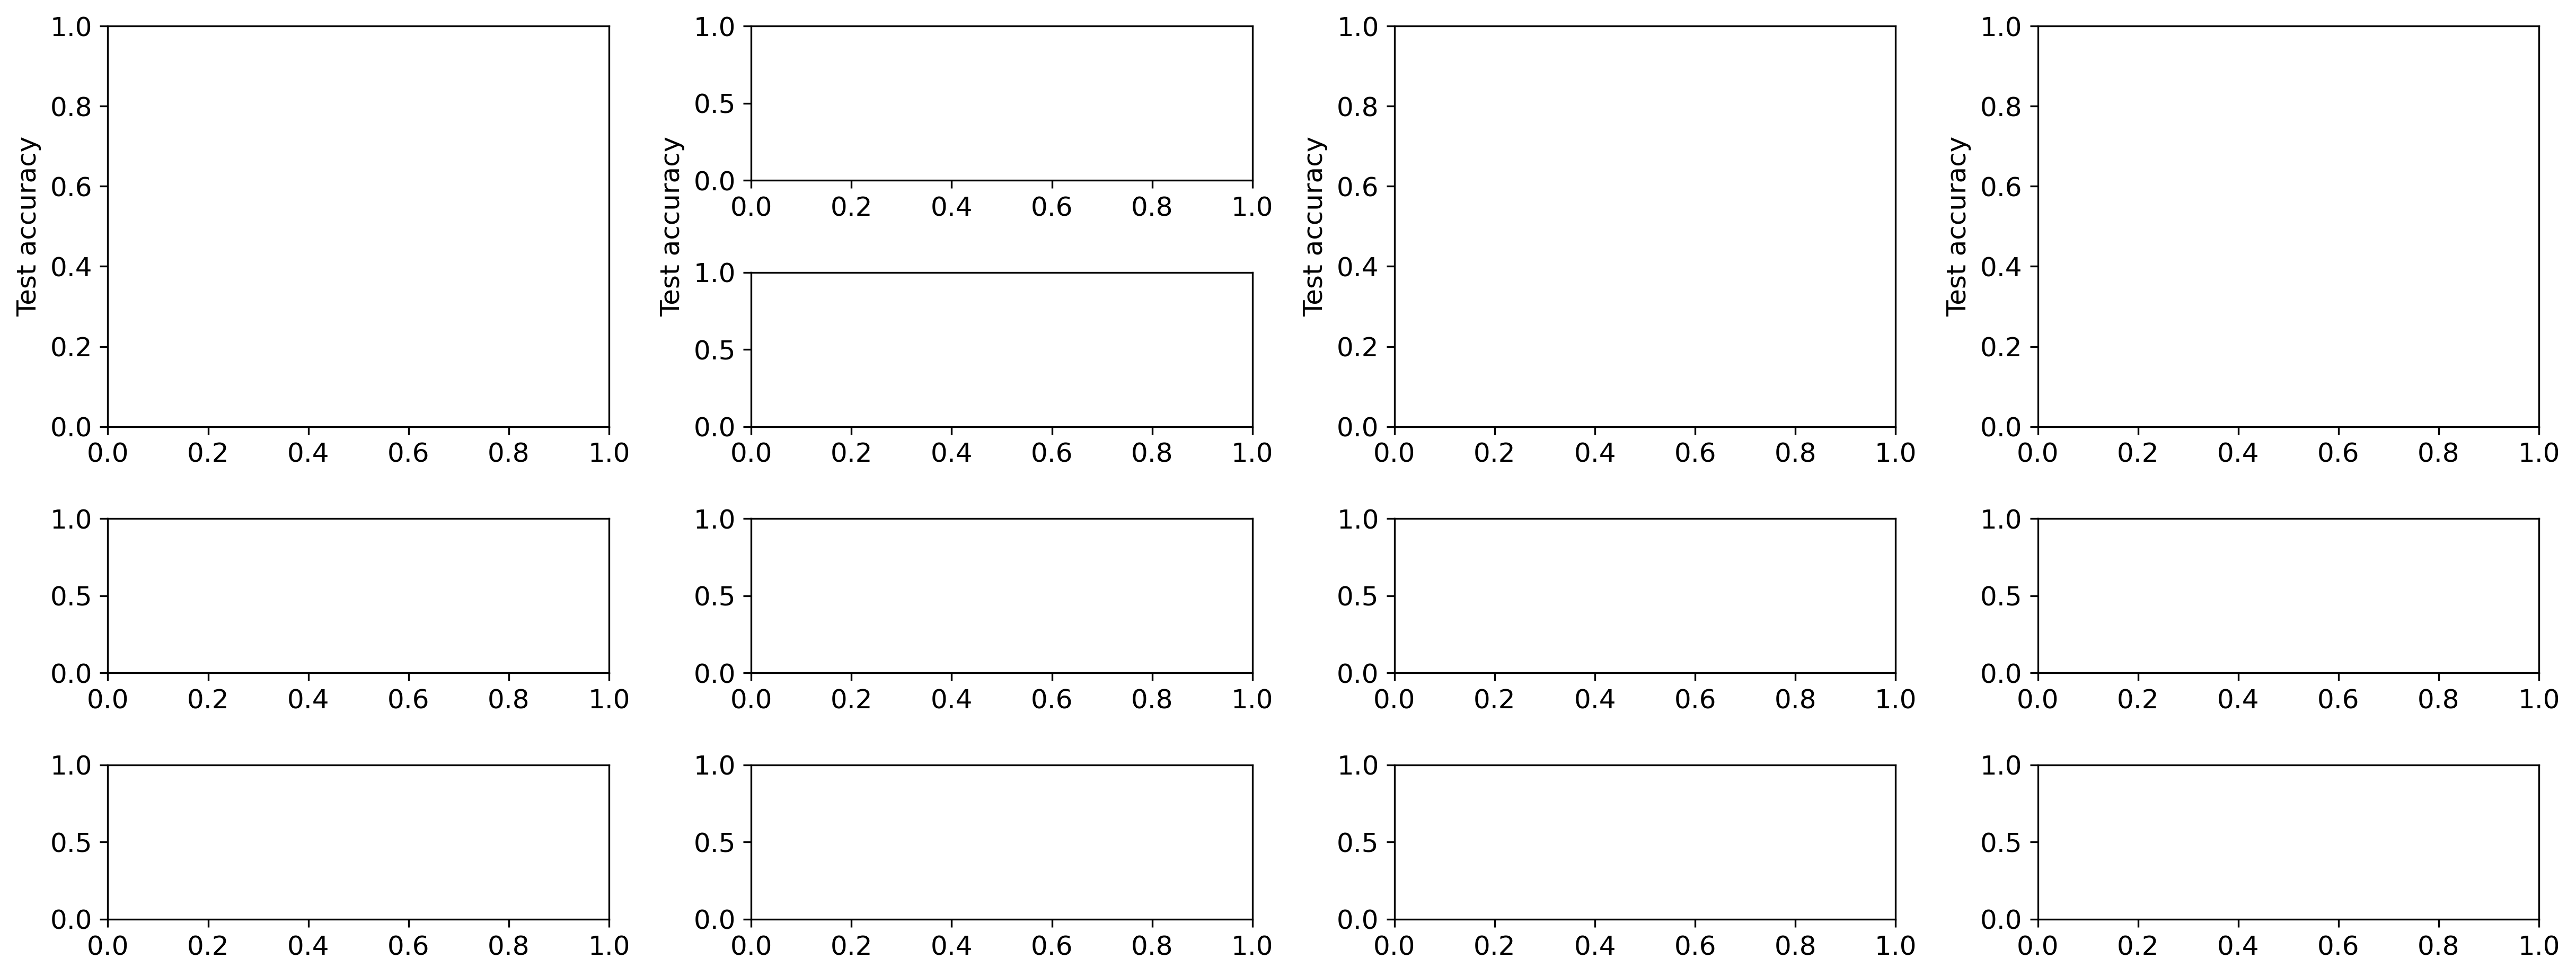

In [94]:
def set_ylabel(fig, grid):
    ax = fig.add_subplot(grid)
    ax.set_frame_on(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.set_ylabel('Test accuracy')

ncols, nrows = 4, 4
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 1.5*nrows), ncols=ncols, nrows=nrows)
grid = plt.GridSpec(nrows=nrows, ncols=ncols)

axs[0,0].axis('off')
axs[1,0].axis('off')
ax = fig.add_subplot(grid[0:2,0])
ax.set_ylabel('Test accuracy')

set_ylabel(fig, grid[0:2,1])

axs[0,2].axis('off')
axs[1,2].axis('off')
ax = fig.add_subplot(grid[0:2,2])
ax.set_ylabel('Test accuracy')

axs[0,3].axis('off')
axs[1,3].axis('off')
ax = fig.add_subplot(grid[0:2,3])
ax.set_ylabel('Test accuracy')


fig.tight_layout(pad=0.0, h_pad=None, w_pad=-1.08)
plt.show()

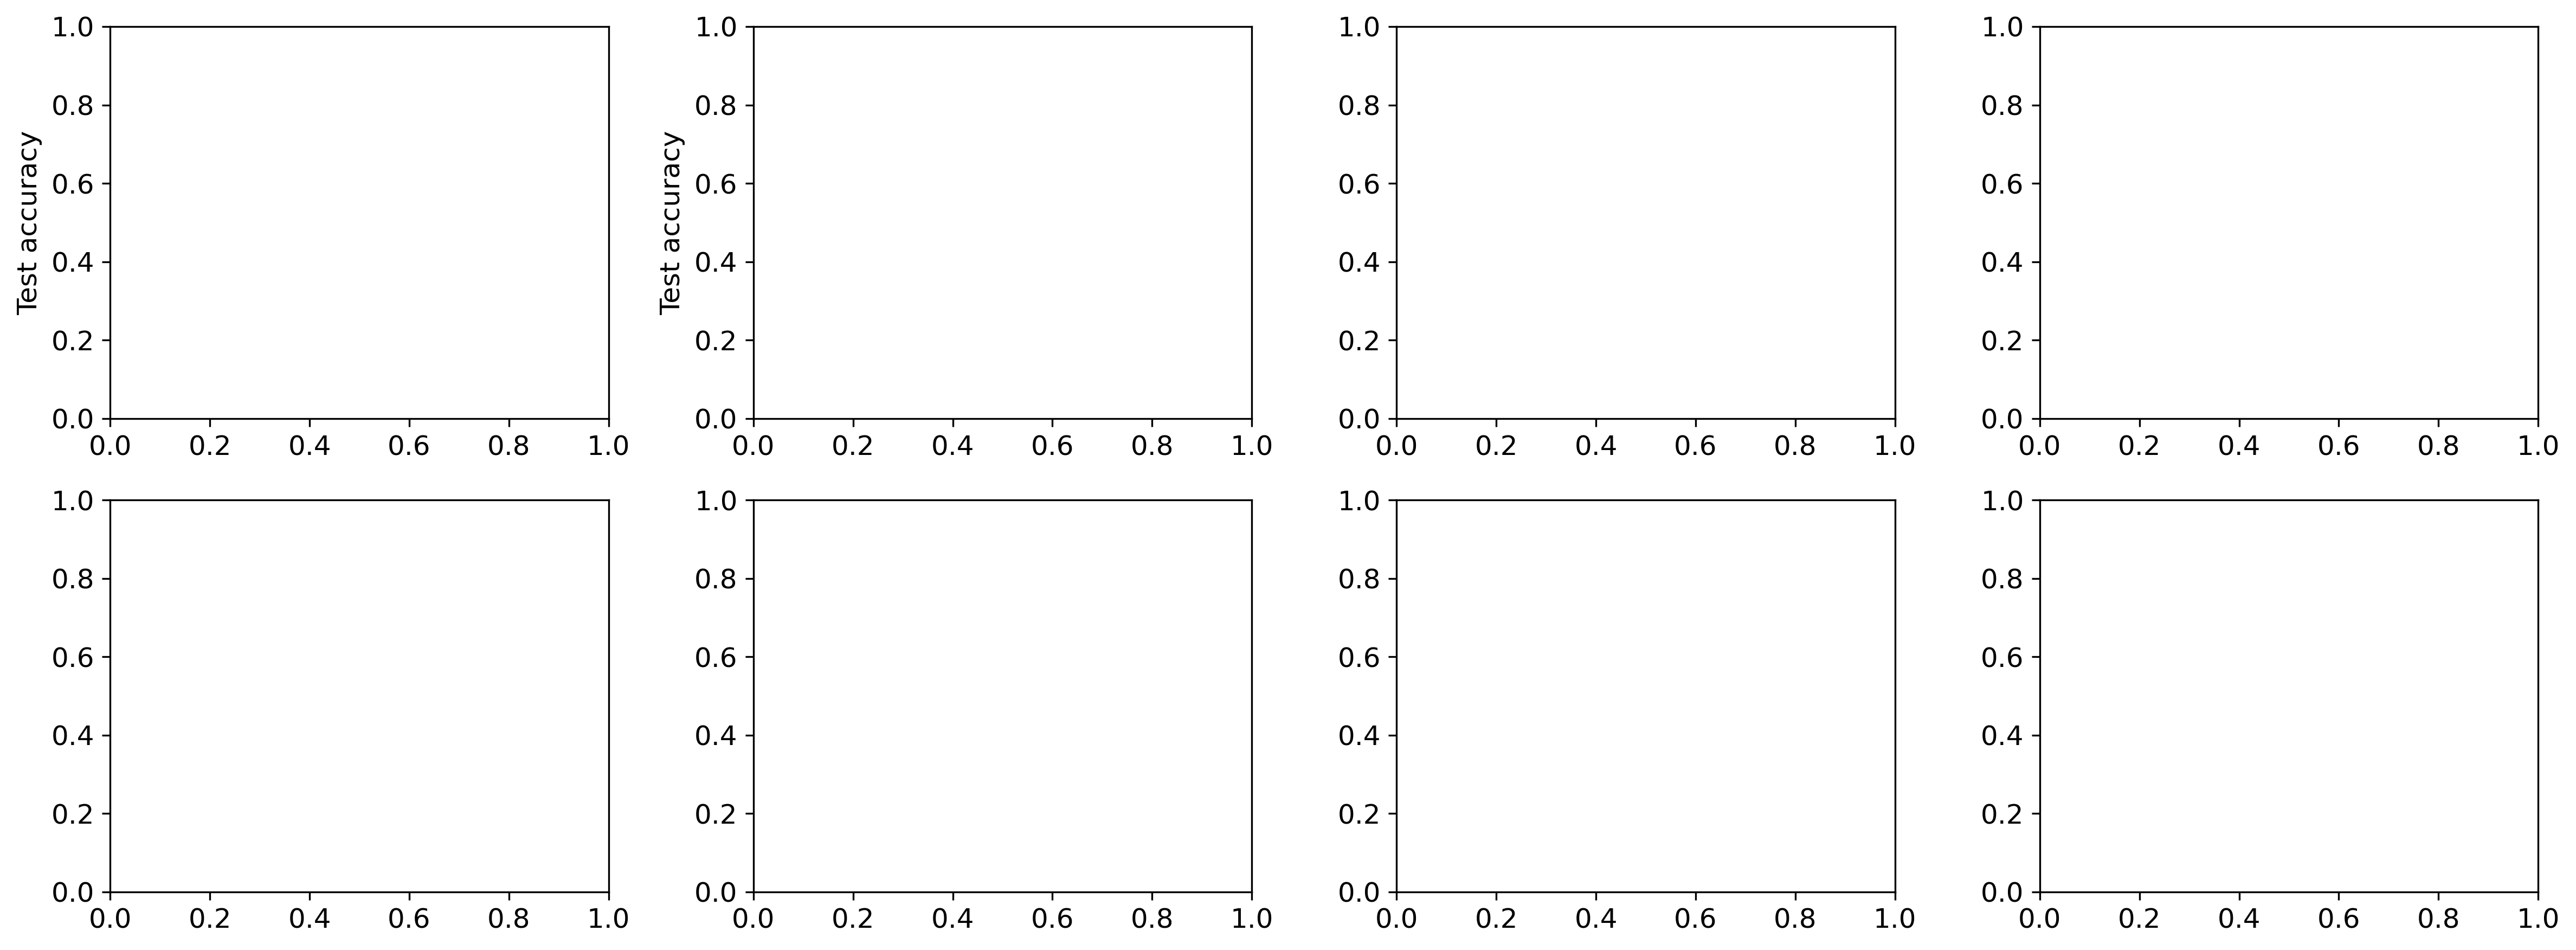

In [91]:
ncols, nrows = 4, 2
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)
axs[0,0].set_ylabel('Test accuracy')
axs[0,1].set_ylabel('Test accuracy')
fig.tight_layout()
plt.show()